In [2]:
import warnings
warnings.simplefilter("ignore")

import sys
import glob
import pickle
import hashlib
import PIL
from os.path import splitext, basename, join, isfile
from collections import defaultdict, Counter
from PIL import Image
from io import BytesIO
import pandas as pd
import numpy as np

from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform

from delf import feature_io
sys.path.append('/home/alexandrearaujo/library/faiss/')
import faiss

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd

In [3]:
def sanitize(x):
    """ convert array to a c-contiguous float array """
    return np.ascontiguousarray(x.astype('float32'))

In [191]:
# image_query_name = 'hertford_000056'
# image_index_name = 'oxford_000317'
# path_to_image = '/home/alexandrearaujo/models/research/delf/delf/python/examples/data/oxford5k_images/'
# path_to_features = '/home/alexandrearaujo/models/research/delf/delf/python/examples/data/oxford5k_features/'

# image_query_name = '4f4b811a065c1423_resize'
# image_index_name = '4e899444d83ca6b2_resize'
# path_to_image = '/home/alexandrearaujo/models/research/delf/delf/python/examples/'
# path_to_features = '/home/alexandrearaujo/models/research/delf/delf/python/examples/data/'

# image_query_name = '4f4b811a065c1423' # big ben
# image_index_name = '4e899444d83ca6b2' # big ben
# path_to_image = '/media/hdd1/kaggle/landmark-retrieval-challenge/index_256x256/'
# path_to_features = '/media/hdd1/kaggle/landmark-retrieval-challenge/feature_index_256x256/'

image_query_name = 'test_256x256/c248b93057261677' # bed
image_index_name = 'index_256x256/b4ffb7950161828c' # city
path_to_image = '/media/hdd1/kaggle/landmark-retrieval-challenge/'
path_to_features = '/media/hdd1/kaggle/landmark-retrieval-challenge/feature_'

# image_query_name = 'test_rescale/c248b93057261677' # bed
# image_index_name = 'index_rescale/b4ffb7950161828c' # city
# path_to_image = '/media/hdd1/kaggle/landmark-retrieval-challenge/'
# path_to_features = '/media/hdd1/kaggle/landmark-retrieval-challenge/feature_'

# path to image
image_query_path = '{}{}.jpg'.format(path_to_image, image_query_name)
image_index_path = '{}{}.jpg'.format(path_to_image, image_index_name)

# path to features
path_features_query = '{}{}.delf'.format(path_to_features, image_query_name)
path_features_index = '{}{}.delf'.format(path_to_features, image_index_name)

# load features
loc_query, _, desc_query, _, _ = feature_io.ReadFromFile(path_features_query)
loc_index, _, desc_index, _, _ = feature_io.ReadFromFile(path_features_index)

desc_index = sanitize(desc_index)
desc_query = sanitize(desc_query)

n_features_index = loc_index.shape[0]
n_features_query = loc_query.shape[0]

print(desc_query.shape)
print(desc_index.shape)

(850, 40)
(1000, 40)


In [192]:
# See the chapter about IndexIVFFlat for the setting of ncentroids. 
# The code_size is typically a power of two between 4 and 64. 
# Like for IndexPQ, d should be a multiple of m.

# faiss
d = 40 # dim of descriptors
nlist = 2**5
m = 10 # number of subquantizers
quantizer = faiss.IndexFlatL2(d)  # this remains the same
n_bits = 4 # should be 8 # bits allocated per subquantizer

index = faiss.IndexIVFPQ(quantizer, d, nlist, m, n_bits)
index.train(desc_index)
index.add(desc_index)
D, I = index.search(desc_query, 60)

# index = faiss.IndexFlatL2(d)  # this remains the same
# index.train(desc_index)
# index.add(desc_index)
# loc_, D, I = index.range_search(desc_query, 0.8)

In [193]:
I[D > 0.8] = -1
indices = I.flatten()
print(len(indices[indices != -1]))

5828


In [194]:
# Select feature locations for putative matches
loc_index_to_use = np.array([
  loc_index[indices[i],]
  for i in range(n_features_query)
  if indices[i] != -1
])

loc_query_to_use = np.array([
  loc_query[i,]
  for i in range(n_features_query)
  if indices[i] != -1
])
print(len(loc_index_to_use), len(loc_query_to_use))

43 43


In [195]:
# Perform geometric verification using RANSAC.
_, inliers = ransac(
  (loc_index_to_use, loc_query_to_use),
  AffineTransform,
  min_samples=3,
  residual_threshold=20,
  max_trials=1000)
nb_inliers = 0 if inliers is None else np.sum(inliers)
print(nb_inliers)

6


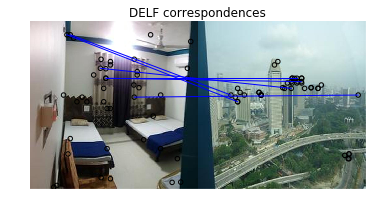

In [196]:
# Visualize correspondences, and save to file.
_, ax = plt.subplots()
img_1 = mpimg.imread(image_query_path)
img_2 = mpimg.imread(image_index_path)
inlier_idxs = np.nonzero(inliers)[0]
plot_matches(
  ax,
  img_1,
  img_2,
  loc_query_to_use,
  loc_index_to_use,
  np.column_stack((inlier_idxs, inlier_idxs)),
  matches_color='b')
ax.axis('off')
ax.set_title('DELF correspondences')
plt.show()

indices 124
33
33
Found 10 inliers


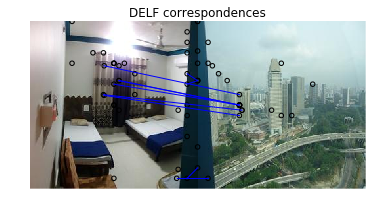

In [165]:
# Find nearest-neighbor matches using a KD tree.
d1_tree = cKDTree(desc_index)
_, indices = d1_tree.query(
  desc_query, distance_upper_bound=0.8)

print('indices', len(indices))

# Select feature locations for putative matches.
loc_index_to_use = np.array([
  loc_index[indices[i],]
  for i in range(n_features_query)
  if indices[i] != n_features_index
])
loc_query_to_use = np.array([
  loc_query[i,]
  for i in range(n_features_query)
  if indices[i] != n_features_index
])

print(len(loc_index_to_use))
print(len(loc_query_to_use))

# Perform geometric verification using RANSAC.
_, inliers = ransac(
  (loc_index_to_use, loc_query_to_use),
  AffineTransform,
  min_samples=3,
  residual_threshold=20,
  max_trials=1000)

print('Found %d inliers' % sum(inliers))


# Visualize correspondences, and save to file.
_, ax = plt.subplots()
img_1 = mpimg.imread(image_query_path)
img_2 = mpimg.imread(image_index_path)
inlier_idxs = np.nonzero(inliers)[0]
plot_matches(
  ax,
  img_1,
  img_2,
  loc_query_to_use,
  loc_index_to_use,
  np.column_stack((inlier_idxs, inlier_idxs)),
  matches_color='b')
ax.axis('off')
ax.set_title('DELF correspondences')
plt.show()

In [105]:
loc_index_to_use

array([[ 64.        , 128.        ],
       [ 96.        , 176.        ],
       [135.76580811,  67.88290405],
       [112.        ,  64.        ],
       [128.        ,  64.        ],
       [128.        ,  64.        ],
       [128.        ,  64.        ],
       [ 64.        ,  16.        ],
       [224.        ,   0.        ],
       [128.        ,  64.        ],
       [128.        ,  64.        ],
       [144.        , 128.        ],
       [128.        ,  64.        ],
       [ 90.51053619,   0.        ],
       [135.76580811,  67.88290405],
       [ 80.        ,  32.        ],
       [128.        ,  64.        ],
       [144.        ,  64.        ],
       [ 90.51053619,   0.        ],
       [135.76580811, 113.13817596],
       [ 64.        ,   0.        ],
       [ 45.25526428,   0.        ],
       [  0.        ,   0.        ],
       [ 32.        ,  16.        ],
       [ 90.51053619,   0.        ],
       [192.        ,   0.        ],
       [  0.        ,   0.        ],
 

In [106]:
loc_query_to_use

array([[240.        , 128.        ],
       [ 48.        , 112.        ],
       [112.        , 160.        ],
       [ 67.88290405, 113.13817596],
       [ 80.        , 160.        ],
       [ 67.88290405, 135.76580811],
       [ 64.        , 144.        ],
       [ 16.        , 240.        ],
       [240.        , 240.        ],
       [ 90.51054382, 135.76580811],
       [ 64.        , 128.        ],
       [128.        , 128.        ],
       [ 96.        , 128.        ],
       [ 80.        , 240.        ],
       [112.        , 112.        ],
       [ 64.        , 128.        ],
       [ 64.        , 128.        ],
       [113.13817596, 113.13817596],
       [176.        , 240.        ],
       [128.        , 128.        ],
       [128.        , 240.        ],
       [135.76580811, 226.27635193],
       [ 32.        , 240.        ],
       [ 48.        , 240.        ],
       [144.        , 240.        ],
       [226.27635193, 226.27635193],
       [  0.        ,  64.        ],
 

In [11]:
def resize_image(image, target_size=800):
  def calc_by_ratio(a, b):
    return int(a * target_size / float(b))

  size = image.size
  if size[0] < size[1]:
    w = calc_by_ratio(size[0], size[1])
    h = target_size
  else:
    w = target_size
    h = calc_by_ratio(size[1], size[0])

  # image = image.resize((w, h), Image.BILINEAR)
  image = image.resize((w, h), Image.ANTIALIAS)
  return image

filename = splitext(basename(image_query_path))[0]
img = Image.open(image_query_path)
img = resize_image(img)
out ='/media/hdd1/kaggle/landmark-retrieval-challenge/test_rescale/{}.jpg'.format(filename)
print(out)
# img.save(out)

filename = splitext(basename(image_index_path))[0]
img = Image.open(image_index_path)
img = resize_image(img)
out = '/media/hdd1/kaggle/landmark-retrieval-challenge/index_rescale/{}.jpg'.format(filename)
print(out)
img.save(out)

/media/hdd1/kaggle/landmark-retrieval-challenge/test_rescale/c248b93057261677.jpg
/media/hdd1/kaggle/landmark-retrieval-challenge/index_rescale/b4ffb7950161828c.jpg
